## Pathway enrichment 

**Input:** 
<ul>
    <li> KEGG pathways and associated genes </li>
    <li> Ovarian and CCLE mRNA-protein correlation (Table S1)</li>
    <li> Proteomic and transcriptomic reproducibility (Table S2) </li>
</ul>          


Here we perform Kolmogorov-Smirnov test, Wilcoxon rank sum tests, Mann-whittney U-test to identify the pathways that are enriched before and after accounting for experimental reproducibility for ovarian and CCLE mRNA-protein correlation! 

In [1]:
import os, ast, math
%matplotlib inline
import numpy as np
import pandas as pd 
import seaborn as sns
import statsmodels.api as sm
from matplotlib import pyplot as plt
import matplotlib as mpl
import graphing_utils 
from scipy.stats import ks_2samp, ranksums, mannwhitneyu
from statsmodels.stats.multitest import multipletests, fdrcorrection

In [2]:
get_local_data_path = lambda folders, fname: os.path.normpath('../local_data/'+'/'.join(folders) +'/'+ fname)
get_figure_path = lambda fname: os.path.normpath('../figures/'+ fname)

file_kegg_pathway_info = get_local_data_path(['processed'], 'kegg_pathways.csv')

file_mRNA_protein_correlation = get_local_data_path(['results'], 'TableS1.xlsx')
file_protein_reproducibility = get_local_data_path(['results'], 'TableS2.xlsx')
file_pathway_enrichment_ccle = get_local_data_path(['results'], 'TableS3.xlsx')
file_pathway_enrichment_ov = get_local_data_path(['results'], 'TableS4.xlsx')
file_transcriptomic_reproducibility_cor = get_local_data_path(['processed', 'correlation_replicates'], 
                                                              'transcriptomic_reproducibility.xlsx')

In [3]:
mRNA_protein_correlation = pd.read_excel(file_mRNA_protein_correlation, sheet_name='A. mRNA-protein correlation', 
                                         index_col=0)
mRNA_protein_correlation[:2]

,CRC (2014),BrCa (2016),Ovarian,Colon,ccRCC,EC,LUAD,BrCa (2020),HNSCC,GBM,NCI60,CCLE,GTEx
Gene symbol,,,,,,,,,,,,,
A1BG,0.123133,-0.093805,-0.078889,NaN,0.035573,0.324974,-0.119663,0.077242,0.065872,-0.192863,NaN,NaN,0.154523
A1CF,NaN,NaN,NaN,0.673548,0.908613,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.188605


In [4]:
ovarian_mRNA_protein_rho = mRNA_protein_correlation['Ovarian'].dropna()
ccle_mRNA_protein_rho = mRNA_protein_correlation['CCLE'].dropna()

In [5]:
aggregated_rank = pd.read_excel(file_protein_reproducibility, sheet_name='B. Protein reproducibility rank', 
                                index_col=0, usecols=['Unnamed: 0', 'Aggregated Reproducibility Rank'], 
                                squeeze=True).dropna()
aggregated_rank[:2]

A1BG    0.575671
A2M     0.501120
Name: Aggregated Reproducibility Rank, dtype: float64

In [6]:
correlation_transcriptomics = pd.read_excel(file_transcriptomic_reproducibility_cor, sheet_name='Reproducibility',
                                            index_col=0, squeeze=True)
correlation_transcriptomics[:2]

A1BG      0.758553
A4GALT    0.866460
Name: CCLE-Klijn, dtype: float64

In [7]:
def get_matched_index(x1, x2):
    common_proteins = x1.index[x1.index.isin(x2.index)]
    print('# Common proteins: ', len(common_proteins))
    return x1.reindex(common_proteins), x2.reindex(common_proteins)

def ols_fit(x, y, match_subsets=True):
    x_subset, y_subset = get_matched_index(x, y) 
    est = sm.OLS(y_subset, sm.add_constant(x_subset.astype(float))).fit()
    return est

In [8]:
combined_df = pd.concat([aggregated_rank, correlation_transcriptomics], axis=1, join='inner')
combined_df.columns=['Aggregated Ranks', 'Transcriptomic replicate correlation']
print("Number of common proteins between CCLE transcriptomic and aggregated data: ", len(combined_df))

Number of common proteins between CCLE transcriptomic and aggregated data:  4795


In [9]:
print("Regressing mRNA-protein correlation using CCLE Transcriptomic and Aggregated subset")
residuals_ov = ols_fit(x=combined_df, y = ovarian_mRNA_protein_rho).resid
residuals_ccle = ols_fit(x=combined_df, y = ccle_mRNA_protein_rho).resid

Regressing mRNA-protein correlation using CCLE Transcriptomic and Aggregated subset
# Common proteins:  4231
# Common proteins:  4676


C:\Users\swath\Anaconda3\envs\omics_reproducibility\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [10]:
ov_combined_df = pd.concat([ovarian_mRNA_protein_rho.rename('mRNA-protein-Rho'), 
                            residuals_ov.rename('Residuals')], axis=1, join='inner')
ov_combined_df[:2]

,mRNA-protein-Rho,Residuals
A1BG,-0.078889,-0.534954
AAAS,0.348565,-0.031504


In [11]:
ccle_combined_df = pd.concat([ccle_mRNA_protein_rho.rename('mRNA-protein-Rho'), 
                            residuals_ccle.rename('Residuals')], axis=1, join='inner')
ccle_combined_df[:2]

,mRNA-protein-Rho,Residuals
AAAS,0.054040,-0.368393
AACS,0.446383,-0.119626


In [12]:
pathways = pd.read_csv(file_kegg_pathway_info, index_col=0)
print(pathways.shape)
pathways.Genes = pathways.Genes.apply(lambda s: list(ast.literal_eval(s)))
pathways[:2]

(334, 2)


,Name,Genes
Code,,
hsa00010,Glycolysis / Gluconeogenesis,"[HK3, HK1, HK2, HKDC1, GCK, GPI, PFKM, PFKP, P..."
hsa00020,Citrate cycle (TCA cycle),"[CS, ACLY, ACO2, ACO1, IDH1, IDH2, IDH3B, IDH3..."


In [13]:
previously_enriched_genesets = ['Arginine and proline metabolism', 'Butanoate metabolism', 'Fatty acid metabolism', 
                                'Ribosome', 'Oxidative phosphorylation', 'Spliceosome', 'PPAR signaling pathway',
                                'Complement and coagulation cascades', 'Purine metabolism', 'Pyrimidine metabolism', 
                                'Alanine, aspartate and glutamate metabolism', 'Glycine, serine and threonine metabolism', 
                                'Cysteine and methionine metabolism', 'Valine, leucine and isoleucine degradation',
                                'Valine, leucine and isoleucine biosynthesis', 'Lysine biosynthesis', 'Lysine degradation',
                                'Arginine biosynthesis', 'Histidine metabolism', 'Ubiquitin mediated proteolysis',
                                'Tyrosine metabolism', 'Phenylalanine metabolism', 'Tryptophan metabolism', 
                                'Glycolysis' ,' Phenylalanine, tyrosine and tryptophan biosynthesis', 'RNA polymerase', 
                                'Galactose metabolism', 'Glycosylphosphatidylinositol (GPI)-anchor biosynthesis',
                                'Arachidonic acid metabolism', 'Glutathione metabolism', 'Glycerolipid metabolism',
                                'Biosynthesis of unsaturated fatty acids', 'mRNA surveillance pathway',
                                'Toll-like receptor signaling pathway', 'DNA Replication', 'Focal adhesion', 
                                'ECM-receptor interaction', 'Proteasome', 'Cell adhesion molecules']

In [14]:
kegg_categories_map = {'Metabolism': ['Oxidative phosphorylation', 'Purine metabolism', 'Glutathione metabolism', 
                                      'Arachidonic acid metabolism', 'Glycerolipid metabolism', 
                                      'Arginine and proline metabolism', 'Butanoate metabolism', 'Fatty acid metabolism',
                                      'Biosynthesis of unsaturated fatty acids','Purine metabolism', 
                                      'Pyrimidine metabolism', 'Alanine, aspartate and glutamate metabolism', 
                                      'Glycine, serine and threonine metabolism', 'Cysteine and methionine metabolism', 
                                      'Valine, leucine and isoleucine degradation', 'Lysine degradation',
                                      'Valine, leucine and isoleucine biosynthesis', 'Lysine biosynthesis', 
                                      'Arginine biosynthesis', 'Histidine metabolism', 'Ubiquitin mediated proteolysis',
                                      'Tyrosine metabolism', 'Phenylalanine metabolism', 'Tryptophan metabolism', 
                                      'Glycolysis' ,' Phenylalanine, tyrosine and tryptophan biosynthesis',
                                      'Galactose metabolism'], 
                       'Environmental Information Processing': ['ECM-receptor interaction', 
                                                                  'Cell adhesion molecules'], 
                       'Genetic Information Processing': ['Spliceosome', 'Ribosome', 'RNA transport', 'RNA polymerase',
                                                           'DNA replication', 'Ribosome biogenesis in eukaryotes', 
                                                           'Homologous recombination',
                                                           'mRNA surveillance pathway', 'Proteasome']}

def add_category(dataframe, column):
    d = dict((k,v) for v, x in kegg_categories_map.items() for k in x)
    dataframe.insert(len(dataframe.columns), 'KEGG Category', dataframe.index.map(d))
    dataframe = dataframe.dropna(subset = ['KEGG Category'])

    dataframe = dataframe.assign(**{'KEGG Category':pd.Categorical(dataframe["KEGG Category"], 
                                                categories=['Environmental Information Processing', 'Metabolism', 
                                                            'Genetic Information Processing'])})
    dataframe = dataframe.sort_values(by=['KEGG Category','Median mRNA-protein correlation', column], 
                                      ascending=[True, True, True])
    return dataframe

In [15]:
def plot_pvalues(pvalues, method): 
    f, ax = plt.subplots(1, 1, figsize=(2,1.7), sharey=False)
    sns.histplot(x=pvalues, ax=ax, bins=25); ax.set_xlabel(method + ' p-value')
    plt.tight_layout()        

In [16]:
pvalue_str = 'pvalue' ; padjust_str = 'padjust' ; FDR_str = 'FDR' ; after_str = ' (after)' ; before_str = ' (before)'
    
def perform_enrichment_test(set_of_genes, method='MannWhitney', residual=False):
    pvalues = []; median_scores_higher = []
    for index, row in pathways.iterrows():
        genes_in_pathway = np.intersect1d(row[1], set_of_genes.index)
        genes_not_in_pathway = list(set(set_of_genes.index) - set(genes_in_pathway))
        scores_in_pathways = set_of_genes.reindex(genes_in_pathway)
        scores_not_in_pathways = set_of_genes.reindex(genes_not_in_pathway)
        median_scores_higher.append('Higher' if scores_in_pathways.median() > scores_not_in_pathways.median() else 'Lower')
        if(len(scores_in_pathways) > 3):
            switcher = {
                'KS': ks_2samp(scores_in_pathways, scores_not_in_pathways, alternative='two-sided')[1],
                'Wilcoxon': ranksums(scores_in_pathways, scores_not_in_pathways)[1],
                'MannWhitneyU': mannwhitneyu(scores_in_pathways, scores_not_in_pathways, method='asymptotic')[1]}
            pvalues.append(switcher.get(method)) 
        else:
            pvalues.append(np.nan)
    
    
    if(residual):
        pvalue, padjust, FDR = pvalue_str + after_str, padjust_str + after_str, FDR_str + after_str
        dataframe = pd.DataFrame({'Pathway':pathways['Name'], pvalue:pvalues}).dropna().set_index('Pathway')
        
    else:
        pvalue, padjust, FDR = pvalue_str + before_str, padjust_str + before_str, FDR_str + before_str
        dataframe = pd.DataFrame({'Pathway':pathways['Name'], pvalue:pvalues, 
                                  'Median mRNA-protein correlation': median_scores_higher}).dropna().set_index('Pathway')
        
    dataframe.insert(len(dataframe.columns), padjust, multipletests(dataframe[pvalue], method='bonferroni')[1])
    dataframe.insert(len(dataframe.columns), FDR, fdrcorrection(dataframe[pvalue])[1])
            
    return dataframe

In [17]:
palette=['#E69F00', '#0072B2'] ; hue_order = ['Higher', 'Lower']

def plot_enrichment_bar_graph(dataframe, axes, x1, x2, title):
    sns.barplot(x=x1, y=dataframe.index, ax=axes[0], hue='Median mRNA-protein correlation', 
                data=dataframe, dodge=False, palette=palette, hue_order=hue_order)
    sns.barplot(x=x2, y=dataframe.index, ax=axes[1], hue='Median mRNA-protein correlation', 
                data=dataframe, dodge=False, palette=palette, hue_order=hue_order)
    # configure first axes 
    axes[0].invert_xaxis()
    axes[0].yaxis.tick_right()
    axes[0].spines['right'].set_visible(True)
    axes[0].spines['left'].set_visible(False)  
    axes[0].set_yticklabels([])    
    axes[0].legend().remove()
    axes[0].set_title(title, weight='bold', y=1.05, size=11, loc='left')
    axes[0].set_ylabel(None); 
    
    axes[1].set_ylabel(None); 
    axes[1].set_xlim(0, axes[0].get_xlim()[0])
    axes[1].legend(title='Median mRNA-protein correlation' , title_fontsize=11,
                   fontsize=11, bbox_to_anchor=(1, 0.915))
    
    axes[0].set_xlabel(x1.replace('log10', '$log_{10}$').replace('(', '\n('), fontsize=12, labelpad = 12)
    axes[1].set_xlabel(x2.replace('log10', '$log_{10}$').replace('(', '\n('), fontsize=12, labelpad = 12) 
    
    line_placement_cooridnate = math.log10(0.05)*-1 #D55E00
    axes[0].axvline(line_placement_cooridnate, color='#999', linestyle='-', linewidth=0.75, ymax=1)
    axes[1].axvline(line_placement_cooridnate, color='#999', linestyle='-', linewidth=0.75, ymax=1)

    axes[1].annotate('Environmental\nInformation Processing', xy=(0.15, 0.965), xytext=(0.27, 0.9382),
                     xycoords='axes fraction', fontsize=11, ha='left', va='bottom',
                     bbox=dict(boxstyle='square', fc='white', ec='white'), zorder=10,
                     arrowprops=dict(arrowstyle='-[, widthB=0.75, lengthB=0.5, angleB=0', lw=1))
    axes[1].annotate('Metabolism', xy=(0.6, 0.55), xytext=(0.72, 0.5375),
                     xycoords='axes fraction', fontsize=11, ha='left', va='bottom',
                     bbox=dict(boxstyle='square', fc='white', ec='white'),
                     arrowprops=dict(arrowstyle='-[, widthB=13.5, lengthB=0.5, angleB=0', lw=1))
    axes[1].annotate('Genetic\nInformation\nProcessing', xy=(1, 0.09), xytext=(1.12, 0.0485),
                     xycoords='axes fraction', fontsize=11, ha='left', va='bottom',
                     bbox=dict(boxstyle='square', fc='white', ec='white'),
                     arrowprops=dict(arrowstyle='-[, widthB=3, lengthB=0.5, angleB=0', lw=1))
    
    for yloc, enrichment in zip(range(0, len(dataframe.index)), dataframe.index):
        axes[0].annotate(enrichment, (0.395, yloc), xycoords=('figure fraction', 'data'),
                         ha='center', va='center', size=12)
    plt.subplots_adjust(wspace=1.8)
    plt.show()

In [18]:
ccle_mwu_results = perform_enrichment_test(ccle_combined_df['mRNA-protein-Rho'], method='MannWhitneyU')
ccle_resid_results = perform_enrichment_test(ccle_combined_df['Residuals'], method='MannWhitneyU', residual=True)

In [19]:
sheets = ['A. mRNA-protein KEGG pathways', 'B. Residuals KEGG pathways']

writer = pd.ExcelWriter(file_pathway_enrichment_ccle)
ccle_mwu_results.to_excel(writer, sheets[0])
ccle_resid_results.to_excel(writer, sheets[1])

for sheet in sheets:
    writer.sheets[sheet].set_column('B:E', 15)
    writer.sheets[sheet].set_column('A:A', 30)
    writer.sheets[sheet].set_column('C:C', 25)

writer.save()

In [20]:
ccle_mwu_results = ccle_mwu_results[ccle_mwu_results.index.isin(previously_enriched_genesets)].dropna()
print('Dimensions: ', ccle_mwu_results.shape)
ccle_mwu_results[:2]

Dimensions:  (33, 4)


,pvalue (before),Median mRNA-protein correlation,padjust (before),FDR (before)
Pathway,,,,
Galactose metabolism,6.906690e-04,Higher,2.134167e-01,3.744153e-03
Oxidative phosphorylation,2.942354e-21,Lower,9.091874e-19,1.515312e-19


In [21]:

ccle_resid_results = ccle_resid_results[ccle_resid_results.index.isin(previously_enriched_genesets)].dropna()
print('Dimensions: ', ccle_resid_results.shape)
ccle_resid_results[:2]

Dimensions:  (33, 3)


,pvalue (after),padjust (after),FDR (after)
Pathway,,,
Galactose metabolism,2.009515e-01,1.000000e+00,5.348542e-01
Oxidative phosphorylation,2.888229e-26,8.924629e-24,4.462315e-24


In [22]:
ccle_FDR_enriched = ccle_mwu_results[['FDR (before)', 'Median mRNA-protein correlation']]
ccle_FDR_enriched.insert(1, '-log10 FDR (before)', ccle_FDR_enriched['FDR (before)'].apply(math.log10) * -1)
ccle_FDR_enriched[:2]

,FDR (before),-log10 FDR (before),Median mRNA-protein correlation
Pathway,,,
Galactose metabolism,3.744153e-03,2.426646,Higher
Oxidative phosphorylation,1.515312e-19,18.819498,Lower


In [23]:
ccle_resid_FDR_enriched = ccle_resid_results[['FDR (after)']]
ccle_resid_FDR_enriched.insert(1, '-log10 FDR (after)', ccle_resid_FDR_enriched['FDR (after)'].apply(math.log10) * -1)
ccle_resid_FDR_enriched[:2]

,FDR (after),-log10 FDR (after)
Pathway,,
Galactose metabolism,5.348542e-01,0.271765
Oxidative phosphorylation,4.462315e-24,23.350440


In [24]:
combined_ccle_FDR = pd.concat([ccle_FDR_enriched, ccle_resid_FDR_enriched], axis=1)
combined_ccle_FDR_subset = add_category(combined_ccle_FDR, column='-log10 FDR (after)')
print("Dimensions: ", combined_ccle_FDR_subset.shape)
combined_ccle_FDR_subset[:2]

Dimensions:  (28, 6)


,FDR (before),-log10 FDR (before),Median mRNA-protein correlation,FDR (after),-log10 FDR (after),KEGG Category
Pathway,,,,,,
ECM-receptor interaction,1.362461e-10,9.865676,Higher,0.715367,0.145471,Environmental Information Processing
Cell adhesion molecules,5.754581e-10,9.239986,Higher,0.187848,0.726192,Environmental Information Processing


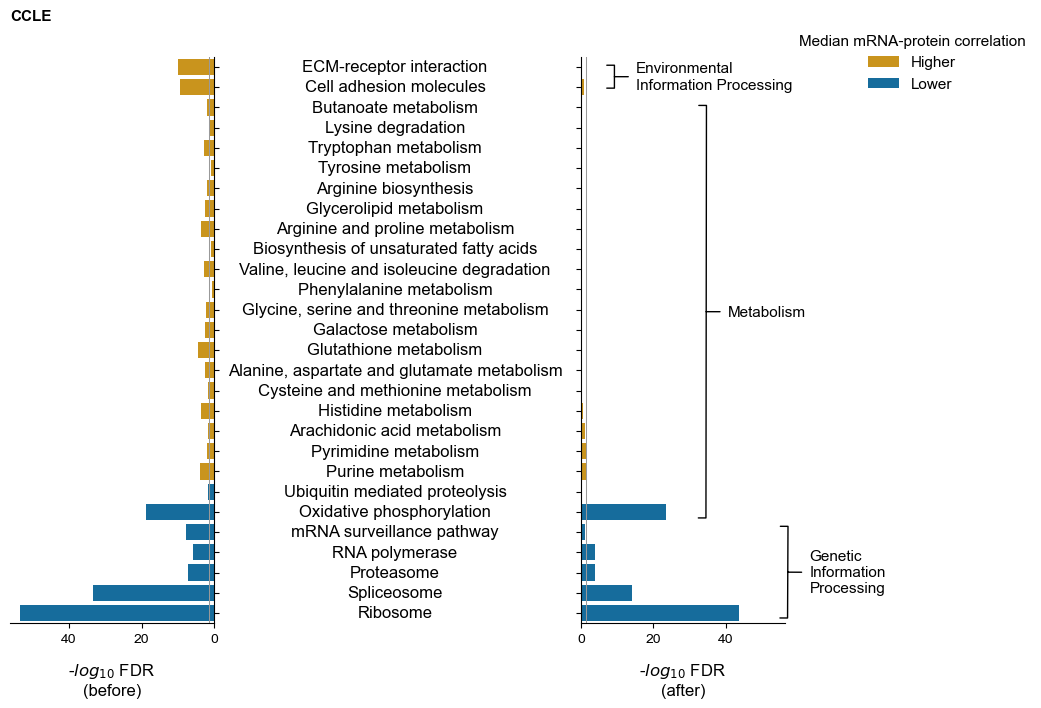

In [25]:
with plt.rc_context({'axes.spines.right': False, 'axes.spines.top': False,'axes.spines.left': True, 
                     'axes.linewidth': 0.8, 'xtick.bottom': True, 'xtick.labelsize':10}):
    figure, axes = plt.subplots(ncols=2, sharey=True, figsize=(10, 7.5))
    plot_enrichment_bar_graph(combined_ccle_FDR_subset, axes, '-log10 FDR (before)', '-log10 FDR (after)', 
                              title='CCLE')
#     figure.savefig(get_figure_path('Figure7.svg'), dpi=300, bbox_inches='tight')

In [26]:
ov_mwu_results = perform_enrichment_test(ov_combined_df['mRNA-protein-Rho'], method='MannWhitneyU')
ov_resid_results = perform_enrichment_test(ov_combined_df['Residuals'], method='MannWhitneyU', residual=True)

In [27]:
sheets = ['A. mRNA-protein KEGG pathways', 'B. Residuals KEGG pathways']

writer = pd.ExcelWriter(file_pathway_enrichment_ov)
ccle_mwu_results.to_excel(writer, sheets[0])
ccle_resid_results.to_excel(writer, sheets[1])

for sheet in sheets:
    writer.sheets[sheet].set_column('A:E', 15)
    writer.sheets[sheet].set_column('C:C', 20)

writer.save()

In [28]:
ov_mwu_results = ov_mwu_results[ov_mwu_results.index.isin(previously_enriched_genesets)].dropna()
print('Dimensions: ', ov_mwu_results.shape)
ov_mwu_results[:2]

Dimensions:  (33, 4)


,pvalue (before),Median mRNA-protein correlation,padjust (before),FDR (before)
Pathway,,,,
Galactose metabolism,3.108659e-02,Higher,1.000000e+00,1.004727e-01
Oxidative phosphorylation,8.911393e-14,Lower,2.780355e-11,4.633924e-12


In [29]:
ov_FDR_enriched = ov_mwu_results[['FDR (before)', 'Median mRNA-protein correlation']]
ov_FDR_enriched.insert(1, '-log10 FDR (before)', ov_FDR_enriched['FDR (before)'].apply(math.log10) * -1)
ov_FDR_enriched[:2]

,FDR (before),-log10 FDR (before),Median mRNA-protein correlation
Pathway,,,
Galactose metabolism,1.004727e-01,0.997952,Higher
Oxidative phosphorylation,4.633924e-12,11.334051,Lower


In [30]:

ov_resid_results = ov_resid_results[ov_resid_results.index.isin(previously_enriched_genesets)].dropna()
print('Dimensions: ', ov_resid_results.shape)
ov_resid_results[:2]

Dimensions:  (33, 3)


,pvalue (after),padjust (after),FDR (after)
Pathway,,,
Galactose metabolism,5.222030e-01,1.000000e+00,6.650096e-01
Oxidative phosphorylation,1.211311e-16,3.779290e-14,1.259763e-14


In [31]:
ov_resid_FDR_enriched = ov_resid_results[['FDR (after)']]
ov_resid_FDR_enriched.insert(1, '-log10 FDR (after)', ov_resid_FDR_enriched['FDR (after)'].apply(math.log10) * -1)
ov_resid_FDR_enriched[:2]

,FDR (after),-log10 FDR (after)
Pathway,,
Galactose metabolism,6.650096e-01,0.177172
Oxidative phosphorylation,1.259763e-14,13.899711


In [32]:
combined_ov_FDR = pd.concat([ov_FDR_enriched, ov_resid_FDR_enriched], axis=1)
combined_ov_FDR_subset = add_category(combined_ov_FDR, column='-log10 FDR (after)')
print("Dimensions: ", combined_ov_FDR_subset.shape)
combined_ov_FDR_subset[:2]

Dimensions:  (28, 6)


,FDR (before),-log10 FDR (before),Median mRNA-protein correlation,FDR (after),-log10 FDR (after),KEGG Category
Pathway,,,,,,
ECM-receptor interaction,0.131452,0.881233,Higher,0.090379,1.043931,Environmental Information Processing
Cell adhesion molecules,0.000013,4.874306,Higher,0.057117,1.243233,Environmental Information Processing


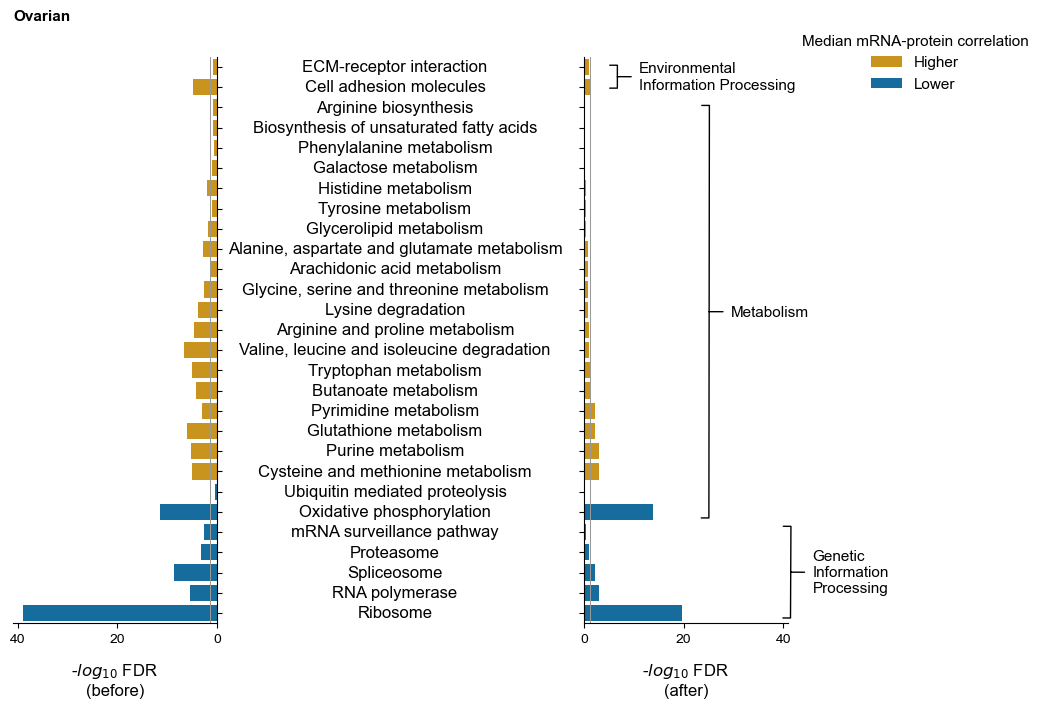

In [33]:
with plt.rc_context({'axes.spines.right': False, 'axes.spines.top': False,'axes.spines.left': True, 
                     'axes.linewidth': 0.8, 'xtick.bottom': True, 'xtick.labelsize':10}):
    figure, axes = plt.subplots(ncols=2, sharey=True, figsize=(10, 7.5))
    plot_enrichment_bar_graph(combined_ov_FDR_subset, axes, '-log10 FDR (before)', '-log10 FDR (after)', 
                              title='Ovarian')

#     figure.savefig(get_figure_path('S6.svg'), dpi=300, bbox_inches='tight')